In [1]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def connection_trim_ag(filename):
    rois=pd.read_csv(filename)
    cnx_check = [col for col in rois if 'cnx' in col]
    num_electrodes=len(rois[cnx_check].columns)
    for elect in range(num_electrodes):
        print cnx_check[elect]
        connections=len(rois[rois[cnx_check[elect]]=='excitatory'].index)
        inhib_cons=len(rois[rois[cnx_check[elect]]=='inhibitory'].index)
        tested=len(rois.index)    
        print 'counted '+str(connections)+' excitatory connections out of '+str(tested)+ ' tested'
        print 'counted '+str(inhib_cons)+' inhibitory connections out of '+str(tested)+ ' tested'
        dists=np.zeros((tested,tested))
        count_test=0
        passedROIs=pd.DataFrame()
        skip=[]
        for test_i in rois.index:
            uhoh=0
            neighbors=[test_i]
            for i in rois.index:
                x_dif=rois['X_mm'][i]-rois['X_mm'][test_i]
                y_dif=rois['Y_mm'][i]-rois['Y_mm'][test_i]
                z_dif=rois['Z_mm'][i]-rois['Z_mm'][test_i]
                xyz_dif=math.sqrt(x_dif**2+y_dif**2+z_dif**2)
                dists[test_i,i]=xyz_dif
                if test_i!=i and xyz_dif < 10 and i >= count_test:            
                    print 'look out! '+ str(test_i) + ' and '+ str(i) + ' are only '+str(xyz_dif)+ ' microns apart'
                    if rois[cnx_check[elect]][test_i]==rois[cnx_check[elect]][i]:
                        uhoh+=1
                        neighbors.append(i)
                        skip.append(i)
                        print '   both ROIs marked '+ rois[cnx_check[elect]][test_i]

            
   
    
            if test_i not in skip:
                passedROIs=passedROIs.append(rois[test_i:test_i+1])
            else: 
                tested-=1
            count_test+=1
        connections=len(passedROIs[passedROIs[cnx_check[elect]]=='excitatory'].index)
        tested=len(passedROIs.index)
        inhib_cons=len(rois[rois[cnx_check[elect]]=='inhibitory'].index)
        print 'updated: counted '+str(connections)+' excitatory connections out of '+str(tested)+ ' tested'
        print 'updated: counted '+str(inhib_cons)+' inhibitory connections out of '+str(tested)+ ' tested'
    return passedROIs

In [186]:
def read_connections_csv(): ## old
    key=pd.read_csv('connections_key.csv', converters={'HS0_class': str, 'HS1_class':str, 'HS0_reporter':str, 'HS1_reporter': str})
    all_dfs={}
    everything=pd.DataFrame()
    for file_i in key.index:
        df_i=connection_trim_ag(key['filename'][file_i]+'.csv')
        ##all_dfs[file_i] = pd.read_csv(key['filename'][file_i]+'.csv')
        all_dfs[file_i]=df_i
        if(key['HS0_angle'][file_i]!='NaN'):
            angle=key['HS0_angle'][file_i]
            centerx=key['HS0_x'][file_i]
            centery=key['HS0_y'][file_i]
            df_i=rotate_rois(df_i,centerx,centery,angle)
        elif(key['HS1_angle'][file_i]!='NaN'):
            angle=key['HS1_angle'][file_i]
            centerx=key['HS1_x'][file_i]
            centery=key['HS1_y'][file_i]            
            df_i=rotate_rois(df_i,centerx,centery,angle)
        else:
            print "no info for rotate"
        df_i['presynapticCre']=key['presynaptic_driver'][file_i]
        df_i['presynaptic_effector']=key['presynaptic_effector'][file_i]
        df_i['HS_class']=key['HS0_class'][file_i]+key['HS1_class'][file_i]
        df_i['HS_reporter']=key['HS0_reporter'][file_i]+key['HS1_reporter'][file_i]
        all_dfs[file_i]=df_i
        everything=everything.append(df_i)
    everything['electrode_x_cnx']=everything['electrode_0_cnx'].fillna('')+everything['electrode_1_cnx'].fillna('')
    everything['electrode_x']=everything.electrode_0.fillna(0)+everything.electrode_1.fillna(0)

    return everything

In [154]:
def read_connections_csv_hsrows():
    key=pd.read_csv('connections_key.csv', converters={'HS0_class': str, 'HS1_class':str, 'HS0_reporter':str, 'HS1_reporter': str})
    
    everything=pd.DataFrame()
    for file_i in key.index:
        df_i=connection_trim_ag(key['filename'][file_i]+'.csv')
        cnx_check=[col for col in df_i if 'cnx' in col]
    
        for cnx in cnx_check:
            electrode_id=cnx[10:11]
            df_electrode=df_i
            df_electrode['electrode_id']=electrode_id
            old_d_name='electrode_'+electrode_id
            old_cnx_name='electrode_'+electrode_id+'_cnx'
            old_z_name='z_electrode_'+electrode_id
            df_electrode=df_electrode.rename(columns={old_d_name: 'xy_dist', old_cnx_name: 'cnx',old_z_name: 'z_dist'})
            HS_angle_name='HS'+electrode_id+'_angle'
            HS_x_name='HS'+electrode_id+'_x'
            HS_y_name='HS'+electrode_id+'_y'
            HS_class_name='HS'+electrode_id+'_class'
            HS_reporter_name='HS'+electrode_id+'_reporter'
            if(key[HS_angle_name][file_i]!='NaN'):
                angle=key[HS_angle_name][file_i]
                centerx=key[HS_x_name][file_i]
                centery=key[HS_y_name][file_i]
                df_electrode=rotate_rois(df_electrode,centerx,centery,angle)
            df_electrode['presynapticCre']=key['presynaptic_driver'][file_i]
            df_electrode['presynaptic_effector']=key['presynaptic_effector'][file_i]
            df_electrode['HS_class']=key[HS_class_name][file_i]
            df_electrode['HS_reporter']=key[HS_reporter_name][file_i]
            everything=everything.append(df_electrode)
    return everything

In [194]:
cnx_row_all=read_connections_csv_hsrows()
cnx_row_all

electrode_0_cnx
counted 0 excitatory connections out of 12 tested
counted 2 inhibitory connections out of 12 tested
look out! 0 and 2 are only 6.02100489952 microns apart
   both ROIs marked no cnx
look out! 1 and 4 are only 6.02100489952 microns apart
   both ROIs marked inhibitory
look out! 5 and 8 are only 6.02100489952 microns apart
   both ROIs marked no cnx
look out! 6 and 10 are only 6.02100489952 microns apart
   both ROIs marked no cnx
look out! 7 and 9 are only 6.02100489952 microns apart
   both ROIs marked no cnx
updated: counted 0 excitatory connections out of 7 tested
updated: counted 2 inhibitory connections out of 7 tested
electrode_0_cnx
counted 0 excitatory connections out of 12 tested
counted 0 inhibitory connections out of 12 tested
look out! 1 and 11 are only 2.21576172004 microns apart
   both ROIs marked tbd
look out! 2 and 7 are only 2.21576172004 microns apart
   both ROIs marked tbd
look out! 3 and 5 are only 2.21576172004 microns apart
   both ROIs marked tbd

updated: counted 0 excitatory connections out of 24 tested
updated: counted 0 inhibitory connections out of 24 tested
electrode_0_cnx
counted 0 excitatory connections out of 27 tested
counted 0 inhibitory connections out of 27 tested
look out! 6 and 10 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 8 and 16 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 9 and 21 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 12 and 23 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 14 and 15 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 17 and 19 are only 5.3 microns apart
   both ROIs marked no cnx
updated: counted 0 excitatory connections out of 21 tested
updated: counted 0 inhibitory connections out of 21 tested
electrode_0_cnx
counted 0 excitatory connections out of 21 tested
counted 0 inhibitory connections out of 21 tested
look out! 0 and 11 are only 7.12364584875 microns apart
   both ROIs marked no cnx
updated:

,HS_class,HS_reporter,Image,MP_ID,Unnamed: 0,X_center,X_mm,X_pix,X_rotate,Y_center,...,Z_mm,cnx,electrode_id,notes,presynapticCre,presynaptic_effector,rad_um,sweeps,xy_dist,z_dist
0,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_4'],0,67.949778,-4482.050222,418,-23.154393,26.790720,...,179.031,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 4, 9, 14, 19, 24, 29, 34, 39, 44, 49])]",75.101498,NaN
1,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_2'],1,-24.457043,-4574.457043,168,0.607277,-19.729151,...,179.031,inhibitory,0,NaN,GAD2,Ai136,5.0,"[[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]]",31.898490,NaN
3,pyr,neg,TSeries-09012017-1015-001,['TSeries_101_1'],3,-21.585047,-4571.585047,176,-43.658464,-75.104082,...,204.911,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([101, 103, 105, 107, 109, 111, 113, 115...",81.634874,NaN
5,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_5'],5,42.949302,-4507.050698,351,39.218537,87.234908,...,179.031,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])]",94.964933,NaN
6,pyr,neg,TSeries-09012017-1015-001,['TSeries_51_3'],6,-1.352878,-4551.352878,231,42.914941,54.886277,...,177.781,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([53, 58, 63, 68, 73, 78, 83, 88, 93, 98])]",50.377880,NaN
7,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_1'],7,-58.634908,-4608.634908,76,92.151998,71.095360,...,179.031,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 1, 6, 11, 16, 21, 26, 31, 36, 41, 46])]",86.221407,NaN
11,pyr,neg,TSeries-09012017-1015-001,['TSeries_101_2'],11,93.923478,-4456.076522,488,-95.602929,-45.989604,...,204.911,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([102, 104, 106, 108, 110, 112, 114, 116...",110.016344,NaN
0,inter,pos,ZSeries-09012017-1015-022,['TSeries_107_1'],0,-82.212639,-4177.212639,58,37.153555,-20.484074,...,156.241,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([107, 111, 115, 119, 123, 127, 131, 135...",89.594466,27.90
1,inter,pos,ZSeries-09012017-1015-022,['TSeries_67_1'],1,-24.999305,-4119.999305,212,2.162382,-18.154119,...,140.531,tbd,0,NaN,GAD2,Ai136,5.0,"[[67, 71, 75, 79, 83, 87, 91, 95, 99, 103]]",33.427989,12.19
2,inter,pos,ZSeries-09012017-1015-022,['TSeries_27_4'],2,-7.654087,-4102.654087,259,6.549049,2.126635,...,139.391,tbd,0,NaN,GAD2,Ai136,5.0,"[[30, 34, 38, 42, 46, 50, 54, 58, 62, 66]]",13.947507,11.05


In [112]:

def rotate_rois(df,cellx,celly,angle):
    angle=angle*np.pi/180
    df['X_center']=df['X_mm']-cellx
    df['Y_center']=(df['Y_mm']-celly)*-1
    df['X_rotate']=df['X_center']*np.cos(angle)-df['Y_center']*np.sin(angle)
    df['Y_rotate']=df['X_center']*np.sin(angle)+df['Y_center']*np.cos(angle)
    return df

In [195]:
pyr=cnx_row_all[cnx_row_all['HS_class']=='pyr']
pyr

,HS_class,HS_reporter,Image,MP_ID,Unnamed: 0,X_center,X_mm,X_pix,X_rotate,Y_center,...,Z_mm,cnx,electrode_id,notes,presynapticCre,presynaptic_effector,rad_um,sweeps,xy_dist,z_dist
0,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_4'],0,67.949778,-4482.050222,418,-23.154393,26.790720,...,179.031,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 4, 9, 14, 19, 24, 29, 34, 39, 44, 49])]",75.101498,NaN
1,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_2'],1,-24.457043,-4574.457043,168,0.607277,-19.729151,...,179.031,inhibitory,0,NaN,GAD2,Ai136,5.0,"[[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]]",31.898490,NaN
3,pyr,neg,TSeries-09012017-1015-001,['TSeries_101_1'],3,-21.585047,-4571.585047,176,-43.658464,-75.104082,...,204.911,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([101, 103, 105, 107, 109, 111, 113, 115...",81.634874,NaN
5,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_5'],5,42.949302,-4507.050698,351,39.218537,87.234908,...,179.031,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])]",94.964933,NaN
6,pyr,neg,TSeries-09012017-1015-001,['TSeries_51_3'],6,-1.352878,-4551.352878,231,42.914941,54.886277,...,177.781,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([53, 58, 63, 68, 73, 78, 83, 88, 93, 98])]",50.377880,NaN
7,pyr,neg,TSeries-09012017-1015-001,['TSeries_1_1'],7,-58.634908,-4608.634908,76,92.151998,71.095360,...,179.031,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 1, 6, 11, 16, 21, 26, 31, 36, 41, 46])]",86.221407,NaN
11,pyr,neg,TSeries-09012017-1015-001,['TSeries_101_2'],11,93.923478,-4456.076522,488,-95.602929,-45.989604,...,204.911,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([102, 104, 106, 108, 110, 112, 114, 116...",110.016344,NaN
0,pyr,neg,TSeries-09012017-1015-021,['TSeries_21_1'],0,81.003440,-3694.296560,449,-31.689387,4.240300,...,126.991,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([21, 23, 25, 27, 29, 31, 33, 35, 37, 39])]",68.691855,NaN
1,pyr,neg,TSeries-09012017-1015-021,['TSeries_1_1'],1,50.455145,-3724.844855,367,-20.268170,3.204765,...,78.251,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([ 1, 3, 5, 7, 9, 11, 13, 15, 17, 19])]",38.370846,NaN
2,pyr,neg,TSeries-09012017-1015-021,['TSeries_41_1'],2,11.104797,-3764.195203,260,-73.709154,74.397827,...,142.171,no cnx,0,NaN,GAD2,Ai136,5.0,"[array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50])]",66.011049,NaN


In [196]:
pyr_no23=pyr[pyr['Y_rotate']<=200]

In [197]:
L5EtoE=pyr_no23[pyr_no23['presynapticCre'].isin(['Slc17a7','Tlx3'])]

In [198]:
Slc2e=pyr[pyr['presynapticCre']=='Slc17a7']
Slc2e

,HS_class,HS_reporter,Image,MP_ID,Unnamed: 0,X_center,X_mm,X_pix,X_rotate,Y_center,...,Z_mm,cnx,electrode_id,notes,presynapticCre,presynaptic_effector,rad_um,sweeps,xy_dist,z_dist
0,pyr,pos,ZSeries-09122017-1131-071,['TSeries_308_1'],0,NaN,-1058.675670,230,NaN,NaN,...,7837.628,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([308, 320, 332, 344, 356, 368, 380, 392...",49.520507,17.64
1,pyr,pos,ZSeries-09122017-1131-071,['TSeries_118_2'],1,NaN,-1003.073368,380,NaN,NaN,...,7854.018,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([119, 131, 143, 155, 167])]",66.727156,1.25
2,pyr,pos,ZSeries-09122017-1131-071,['TSeries_308_12'],2,NaN,-1004.789423,376,NaN,NaN,...,7837.628,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([319, 331, 343, 355, 367, 379, 391, 403...",47.339777,17.64
3,pyr,pos,ZSeries-09122017-1131-071,['TSeries_188_8'],3,NaN,-1069.733995,201,NaN,NaN,...,7874.298,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([195, 207, 219, 231, 243, 255, 267, 279...",34.825049,19.03
4,pyr,pos,ZSeries-09122017-1131-071,"['TSeries_27_9', 'TSeries_58_9']",4,NaN,-999.599842,390,NaN,NaN,...,7854.018,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([35, 47, 59, 71, 83]), array([ 66, 78,...",57.720295,1.25
5,pyr,pos,ZSeries-09122017-1131-071,['TSeries_178_1'],5,NaN,-1056.021870,238,NaN,NaN,...,7846.108,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([178, 179, 180, 181, 182, 183, 184, 185...",64.512219,9.16
6,pyr,pos,ZSeries-09122017-1131-071,['TSeries_188_12'],6,NaN,-1018.734511,338,NaN,NaN,...,7874.298,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([199, 211, 223, 235, 247, 259, 271, 283...",42.977799,19.03
7,pyr,pos,ZSeries-09122017-1131-071,['TSeries_308_5'],7,NaN,-1145.519131,3,NaN,NaN,...,7837.628,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([312, 324, 336, 348, 360, 372, 384, 396...",104.455172,17.64
8,pyr,pos,ZSeries-09122017-1131-071,['TSeries_118_7'],8,NaN,-1103.628954,109,NaN,NaN,...,7854.018,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([124, 136, 148, 160, 172])]",74.784160,1.25
10,pyr,pos,ZSeries-09122017-1131-071,['TSeries_188_1'],10,NaN,-1052.413416,247,NaN,NaN,...,7874.298,no cnx,1,NaN,Slc17a7,ReaChRKv,5.00,"[array([188, 200, 212, 224, 236, 248, 260, 272...",66.070063,19.03


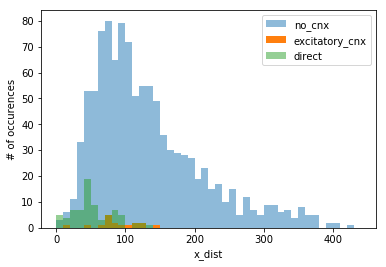

In [199]:
df=pyr

plt.hist(df[df['cnx']=='no cnx']['xy_dist'],bins=range(0,450,10),label='no_cnx',alpha=0.5)
plt.hist(df[df['cnx']=='excitatory']['xy_dist'],bins=range(0,450,10),label='excitatory_cnx')
plt.hist(df[df['cnx']=='tbd']['xy_dist'],bins=range(0,450,10),label='direct',alpha=0.5)


plt.xlabel('x_dist')
plt.ylabel('# of occurences')

plt.legend()
plt.show()

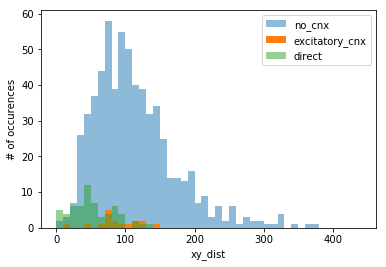

In [200]:
df=L5EtoE

plt.hist(df[df['cnx']=='no cnx']['xy_dist'],bins=range(0,450,10),label='no_cnx',alpha=0.5)
plt.hist(df[df['cnx']=='excitatory']['xy_dist'],bins=range(0,450,10),label='excitatory_cnx')
plt.hist(df[df['cnx']=='tbd']['xy_dist'],bins=range(0,450,10),label='direct',alpha=0.5)


plt.xlabel('xy_dist')
plt.ylabel('# of occurences')

plt.legend()
plt.show()

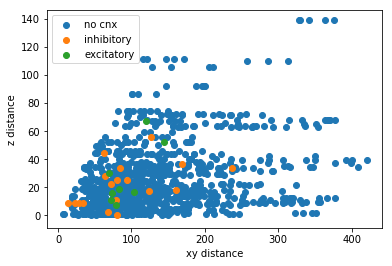

In [201]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

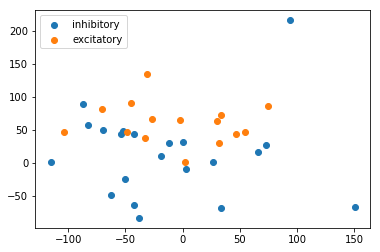

In [167]:
##plt.scatter(pyr[pyr['cnx']=='tbd']['X_rotate'],pyr[pyr['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['X_rotate'],pyr[pyr['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['X_rotate'], pyr[pyr['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.legend()
plt.show()

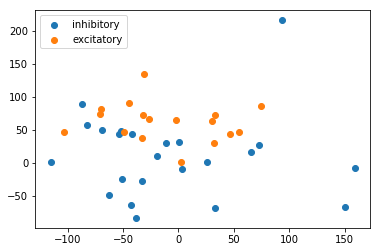

In [202]:
##plt.scatter(pyr[pyr['cnx']=='tbd']['X_rotate'],pyr[pyr['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['X_rotate'],pyr[pyr['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['X_rotate'], pyr[pyr['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.legend()
plt.show()

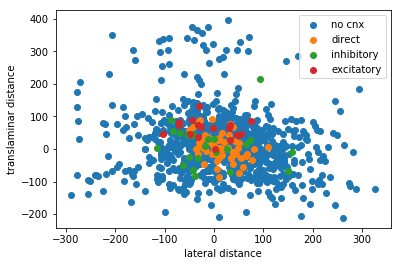

In [203]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['X_rotate'],pyr[pyr['cnx']=='no cnx']['Y_rotate'], label='no cnx')

plt.scatter(pyr[pyr['cnx']=='tbd']['X_rotate'],pyr[pyr['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['X_rotate'],pyr[pyr['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['X_rotate'], pyr[pyr['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.xlabel('lateral distance')
plt.ylabel('translaminar distance')
plt.legend()
plt.show()

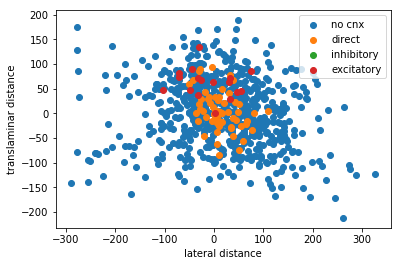

In [204]:
df=L5EtoE

plt.scatter(df[df['cnx']=='no cnx']['X_rotate'],df[df['cnx']=='no cnx']['Y_rotate'], label='no cnx')

plt.scatter(df[df['cnx']=='tbd']['X_rotate'],df[df['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(df[df['cnx']=='inhibitory']['X_rotate'],df[df['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(df[df['cnx']=='excitatory']['X_rotate'], df[df['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.xlabel('lateral distance')
plt.ylabel('translaminar distance')
plt.legend()
plt.show()

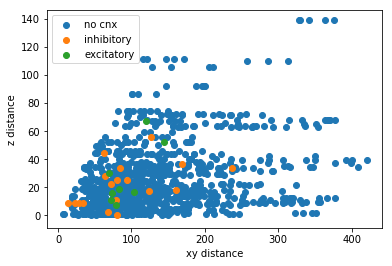

In [205]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

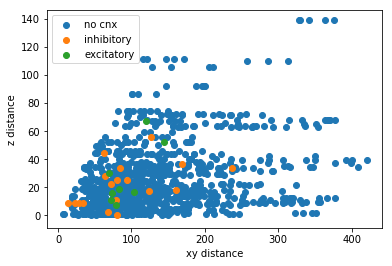

In [206]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

In [183]:
#plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
m,b=np.polyfit(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],1)
print m
print b
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

ValueError: On entry to DGELSD parameter number 6 had an illegal value

In [165]:
def exp_plots_group(exp_df):
    groups=exp_df.groupby('cnx')
    for name, group in groups:
        plt.scatter(group.X_rotate, group.Y_rotate, label=name, alpha=0.3)
    plt.xlabel('x location')
    plt.ylabel('y location')
    plt.legend()
    plt.show()


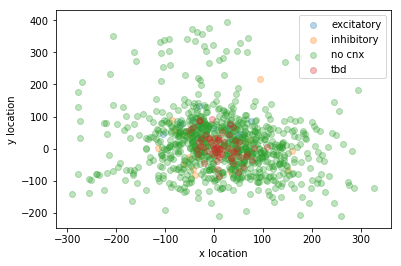

In [207]:
exp_plots_group(pyr)